In [1]:
import pandas as pd
import random
import numpy as np
from transformers import AutoConfig, AutoModel, AutoTokenizer, RobertaTokenizer, BertTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from datetime import datetime
from collections import Counter, defaultdict
import os
import shutil
from itertools import chain
import ast

C:\Users\1\anaconda3\envs\py_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_file_path = "C:/Users/1/Bondarenko/data/combined_solutions.csv"
data = pd.read_csv(csv_file_path)

In [3]:
tag_counts = data['Tags'].value_counts()
threshold = 5
frequent_tags = tag_counts[tag_counts >= threshold].index
data = data[data['Tags'].isin(frequent_tags)]

In [4]:
data.head()
data.info

<bound method DataFrame.info of                                                      Code  \
0       using namespace __gnu_pbds;void __print(int x)...   
1       int main()\n{\nIOS\nint n;\ncin>>n;\nstring a,...   
2       const ll mod = <NUM>;\nint main(){\nFastIO;\nP...   
3       const int M = <NUM>+<NUM>, N =<NUM>+<NUM>;int ...   
4       typedef long long ll;\ntypedef long double lld...   
...                                                   ...   
250514  public final class cutting{\npublic static voi...   
250515  public class Main {\nstatic Scanner sc;\npubli...   
250516  public class Solution{\npublic static void mai...   
250517  public class Main {\npublic static void main(S...   
250518  public class Cutting_493_2_B {\nstatic Scanner...   

                                               Tags Language  
0                                 dp,greedy,strings      cpp  
1                                 dp,greedy,strings      cpp  
2                                 dp,greedy,st

In [5]:
tag_counts = data['Tags'].value_counts()
tag_counts

Tags
implementation                                                         17631
math                                                                    7489
greedy                                                                  6613
brute force,implementation                                              5582
implementation,math                                                     5564
                                                                       ...  
data structures,math,number theory                                         5
chinese remainder theorem,combinatorics,math,number theory                 5
data structures,dfs and similar,graphs,shortest paths,strings,trees        5
greedy,math,probabilities                                                  5
combinatorics,dfs and similar,dp,geometry,trees                            5
Name: count, Length: 1291, dtype: int64

In [6]:
train_df, valid_df = train_test_split(
    data,  # Исходные данные
    test_size=0.2,  # Размер валидационной выборки
    random_state=42,  # Сид для воспроизводимости
    stratify=data['Language']  # Стратификация по столбцу 'Language'
)

print("Размер обучающего набора:", train_df.shape[0])
print("Размер валидационного набора:", valid_df.shape[0])

Размер обучающего набора: 198386
Размер валидационного набора: 49597


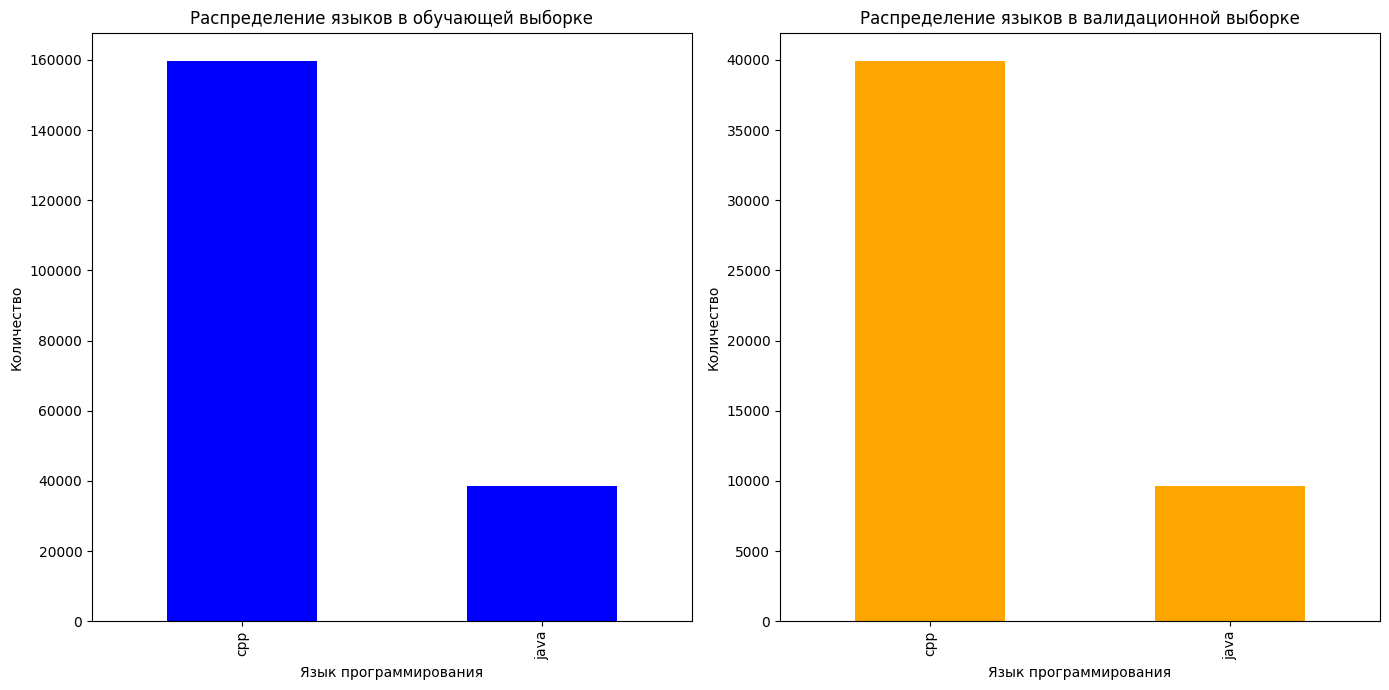

In [7]:
import matplotlib.pyplot as plt
train_language_distribution = train_df['Language'].value_counts()
valid_language_distribution = valid_df['Language'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

train_language_distribution.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Распределение языков в обучающей выборке')
ax[0].set_xlabel('Язык программирования')
ax[0].set_ylabel('Количество')

valid_language_distribution.plot(kind='bar', ax=ax[1], color='orange')
ax[1].set_title('Распределение языков в валидационной выборке')
ax[1].set_xlabel('Язык программирования')
ax[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

In [8]:
data['Tags'].fillna('').astype(str)
exploded_tags = data['Tags'].str.split(',').explode()
unique_tags = exploded_tags.unique()
unique_tags = [tag.strip() for tag in unique_tags if tag]

In [9]:
all_tags = unique_tags

In [10]:
type(all_tags)

list

In [11]:
all_tags

['dp',
 'greedy',
 'strings',
 'dfs and similar',
 'graphs',
 'shortest paths',
 'trees',
 'constructive algorithms',
 'math',
 'games',
 'data structures',
 'string suffix structures',
 'sortings',
 'implementation',
 'bitmasks',
 'brute force',
 'binary search',
 'interactive',
 'probabilities',
 'dsu',
 'two pointers',
 'divide and conquer',
 'combinatorics',
 'meet-in-the-middle',
 'number theory',
 'geometry',
 'hashing',
 'flows',
 'graph matchings',
 '*special',
 'ternary search',
 'fft',
 'matrices',
 'chinese remainder theorem',
 'expression parsing',
 '2-sat',
 'schedules']

In [12]:
model_config = AutoConfig.from_pretrained("microsoft/codebert-base", output_attentions=True)
#model_config = AutoConfig.from_pretrained("bert-base-uncased", output_attentions=True)
model_config

C:\Users\1\anaconda3\envs\py_torch\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


RobertaConfig {
  "_name_or_path": "microsoft/codebert-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [13]:
config = {
    'seed' : 42,
    'tags' : all_tags,
    'batchSize' : 3,
    'lr' : 5e-6,
    'trainMaxLength' : 512,
    'testMaxLength' : 512,
    'numEpochs' : 200,
    'model' : AutoModel.from_config(model_config),
    'tokenizer' : RobertaTokenizer.from_pretrained('microsoft/codebert-base'),
    'gradient_accumulation_steps' : 4,
    'max_grad_norm' : 1.0,
    'task' : 'tag', 
    'save' : True,
}

C:\Users\1\anaconda3\envs\py_torch\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(config['seed'])

In [15]:
config_tags = [tag.lower().strip() for tag in config['tags']]

new_train_idx = []
selected_train_tags = []

for index in train_df.index:
    raw_tags = train_df.loc[index]['Tags']
    if not isinstance(raw_tags, str):
        continue
    row_tags = raw_tags.lower().split(',')

    row_tags = [tag.strip() for tag in row_tags]
    selected_tags = [tag for tag in row_tags if tag in config_tags]
    if selected_tags:
        new_train_idx.append(index)
        selected_train_tags.append(selected_tags)

print(len(new_train_idx))

198386


In [16]:
config_tags = [tag.lower().strip() for tag in config["tags"]]

new_valid_idx = []
selected_valid_tags = []

for index, row in valid_df.iterrows():
    raw_tags = row['Tags']
    if not isinstance(raw_tags, str):
        continue
    row_tags = raw_tags.lower().split(',')
    row_tags = [tag.strip() for tag in row_tags]
    selected_tags = [tag for tag in row_tags if tag in config_tags]
    if selected_tags:
        selected_valid_tags.append(selected_tags)
        new_valid_idx.append(index)

len(new_valid_idx)

49597

In [17]:
train_df = train_df.loc[new_train_idx]
train_df['Tags'] = selected_train_tags

valid_df = valid_df.loc[new_valid_idx]
valid_df['Tags'] = selected_valid_tags

In [18]:
X_train = train_df['Code']
X_test = valid_df['Code']

y_tags_train = train_df['Tags']
y_tags_test = valid_df['Tags']

In [19]:
# Create an instance of the MultiLabelBinarizer
tag_label_encoder = MultiLabelBinarizer()

y_tags_train = tag_label_encoder.fit_transform(y_tags_train)
y_tags_test = tag_label_encoder.transform(y_tags_test)

In [20]:
# Define a class for multi-label classification head
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelClassificationHead(nn.Module):
    def __init__(self, num_labels, hidden_size=768, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)  # Используем LayerNorm вместо BatchNorm
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)  # Используем LayerNorm вместо BatchNorm
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.ln1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.leaky_relu(self.ln2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

class classifier(nn.Module):
    def __init__(self, model, device, tags_num_classes):
        super().__init__()
        self.tags_num_classes = tags_num_classes  
        self.device = device
        self.tags_classifier = MultiLabelClassificationHead(num_labels=self.tags_num_classes).to(self.device)
        self.BCE = nn.BCELoss().to(self.device)  
        self.model = model
        self.lr = config['lr']
        self.task = config['task']

        # Список параметров для оптимизатора
        optimizer_params = [
            {'params': self.model.parameters()},
            {'params': self.tags_classifier.parameters()},
        ]

        # Initialize the optimizer with directly passing the parameters
        self.optimizer = torch.optim.Adam(
            optimizer_params,
            lr=self.lr
        )

    def forward(self, input_ids, attention_mask, tags_labels):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output # Pooled output from the model
        attention_weights = outputs.attentions  # Получение весов внимания

        
        output = self.tags_classifier(pooled_output) # Predict tags using the tags classifier
        loss = self.BCE(output, tags_labels) # Calculate the loss for tags
        return loss, output
        #return loss, output, attention_weights

In [21]:
def tokenize(inputs, file_path):
    tokenized_batches = {'input_ids': [], 'attention_mask': []}
    for input_text in tqdm(inputs, desc='Tokenizing'):
        tokenized_output = tokenizer(input_text, max_length=512, padding='max_length', truncation=True, return_tensors="pt")
        tokenized_batches['input_ids'].append(tokenized_output['input_ids'].squeeze(0))
        tokenized_batches['attention_mask'].append(tokenized_output['attention_mask'].squeeze(0))

    tokenized_batches['input_ids'] = torch.stack(tokenized_batches['input_ids'])
    tokenized_batches['attention_mask'] = torch.stack(tokenized_batches['attention_mask'])

    torch.save(tokenized_batches, file_path)
    print(f"Saved tokenized data to {file_path}")
    return tokenized_batches  # Возврат данных

In [22]:
def convert_to_tensor(data, dtype):
    # Convert data to tensors
    tensor_data = torch.tensor(data, dtype=dtype)
    return tensor_data

In [23]:
class Trainer():
    def __init__(self,
                 model,
                 tokenized_inputs_train,
                 tokenized_inputs_test,
                 tags_labels_train,
                 tags_labels_test
                ):
        # Set the device (GPU or CPU)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Store the input data and labels
        self.tokenized_inputs_train = tokenized_inputs_train
        self.tokenized_inputs_test = tokenized_inputs_test

        self.tags_labels_train = tags_labels_train
        self.tags_labels_test = tags_labels_test

        self.tags_num_classes = len(tags_labels_train[0])

        # Move the model to the specified device
        self.model = model.to(self.device)

        # Define Classifier Instance
        self.classifier_instance = classifier(self.model, self.device, self.tags_num_classes)

        # Retrieve configuration parameters
        self.batch_size = config['batchSize']
        self.num_epochs = config['numEpochs']

        self.accumulation_steps = config['gradient_accumulation_steps']
        self.max_grad_norm = config['max_grad_norm']

        self.tag_classes = tag_label_encoder.classes_

        self.save = config['save']

        # Initialize input data variables
        self.input_ids_train = self.tokenized_inputs_train['input_ids']
        self.attention_mask_train = self.tokenized_inputs_train['attention_mask']

        self.input_ids_test = tokenized_inputs_test['input_ids']
        self.attention_mask_test = tokenized_inputs_test['attention_mask']

        self.task = config['task']
        self.best_attention_weights = None

    def train(self):
    
        input_ids_train = self.input_ids_train
        attention_mask_train = self.attention_mask_train
        tags_labels_train = self.tags_labels_train

        input_ids_test = self.input_ids_test
        attention_mask_test = self.attention_mask_test
        tags_labels_test = self.tags_labels_test

        # Set the optimizer and learning rate
        optimizer = self.classifier_instance.optimizer
        parameters = self.classifier_instance.parameters

        # Set the batch size
        batch_size = self.batch_size

        # Create a DataLoader for batching the data
        train_dataset = TensorDataset(input_ids_train, attention_mask_train, tags_labels_train)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0, pin_memory=True)

        valid_dataset = TensorDataset(input_ids_test, attention_mask_test, tags_labels_test)
        valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

        # Set the number of training epochs#
        num_epochs = self.num_epochs
        device = self.device

        model = self.model
        classifier_instance = self.classifier_instance

        # Training loop
        min_loss = 999999
        total_f1_s = 0
        count = 0

        #epochs

        max_total_f1_macro_score_epochs = 0
        max_tag_acc_epochs = 0
        max_tag_f1_macro_epochs = 0
        max_tag_f1_micro_epochs = 0
        max_tag_f1_weighted_epochs= 0
        max_tag_f1_samples_epochs= 0
        max_tag_roc_auc_score_epochs = 0
        max_tag_precision_macro_epochs = 0
        max_tag_recall_macro_epochs = 0

        #score
        max_total_f1_macro_score = 0
        max_tag_acc = 0
        max_tag_f1_macro = 0
        max_tag_f1_micro = 0
        max_tag_f1_weighted = 0
        max_tag_f1_samples = 0
        max_tag_roc_auc_score = 0
        max_tag_precision_macro = 0
        max_tag_recall_macro = 0
       
        thresholds = [0.001] + [i * 0.01 for i in range(1, 101)]

        for epoch in range(num_epochs):
            train_loss = 0.0
            valid_loss = 0.0

            tags_true = []
            tags_pred = defaultdict(list)
            tags_pred_proba = []

            count += 1

            # Training
            classifier_instance.train()
            # Zero the gradients
            optimizer.zero_grad()
            for batch in tqdm(train_dataloader):
                # Unpack the batch
                input_ids, attention_mask, tags_labels = batch

                # Move the inputs and labels to the chosen device
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                tags_labels = tags_labels.to(device)

                # Forward pass
                loss, _ = classifier_instance(input_ids, attention_mask, tags_labels)
                #loss, _, attention_weights = classifier_instance(input_ids, attention_mask, tags_labels)
                loss /= self.accumulation_steps

                # Backward pass and optimization
                loss.backward()

                if epoch % self.accumulation_steps ==  0 or epoch == batch_size - 1 or self.accumulation_steps == 0:
                    if self.max_grad_norm > 0:

                        torch.nn.utils.clip_grad_norm_(chain(
                            model.parameters(),
                            classifier_instance.tags_classifier.parameters()
                        ), self.max_grad_norm)
                    optimizer.step()
                    optimizer.zero_grad()

                train_loss += loss.item()

            # Validation
            #model.eval()
            classifier_instance.eval()
            with torch.no_grad():
                for batch in tqdm(valid_dataloader):
                    # Unpack the batch
                    input_ids, attention_mask, tags_labels = batch

                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    tags_labels = tags_labels.to(device)

                    # Forward pass
                    loss, output = classifier_instance(input_ids, attention_mask, tags_labels)
                    #loss, output, attention_weights = classifier_instance(input_ids, attention_mask, tags_labels)

                    valid_loss += loss.item()

                    tags_output = output

                    tags_pred_proba.extend(tags_output.detach().cpu().clone().tolist())

                    for threshold in thresholds:
                        tags_pred[threshold].extend([(row >= threshold).nonzero().flatten().tolist() for row in tags_output.detach().cpu().clone()])

                    tags_true.extend([torch.nonzero(row).flatten().tolist() for row in tags_labels.detach().cpu().clone()])

            # Calculate average loss
            train_loss /= len(train_dataset)
            valid_loss /= len(valid_dataset)


            if epoch % self.accumulation_steps ==  0 or epoch == batch_size - 1 or self.accumulation_steps == 0:

                # Print the loss, F1 score, precision, and recall for monitoring
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

                tag_true = []

                

                for index_list in tags_true:
                    result_true = [0] * self.tags_num_classes  # Create a list of length num_classes.
                    for index in index_list:
                        result_true[index] = 1  # Fill the corresponding index with 1.

                    tag_true.append(result_true)


                    epoch_max_tag_acc = 0
                    epoch_max_tag_f1_macro = 0
                    epoch_max_tag_f1_micro = 0
                    epoch_max_tag_f1_weighted = 0
                    epoch_max_tag_f1_samples = 0
                    epoch_max_tag_precision_macro = 0
                    epoch_max_tag_recall_macro = 0

                    epoch_max_tag_roc_auc_score = roc_auc_score(tag_true, tags_pred_proba)
                    tag_true = np.array(tag_true)
                    tags_pred_proba = np.array(tags_pred_proba)

                    for threshold in thresholds:
                        tag_pred = []
                        for index_list in tags_pred[threshold]:
                            result_pred = [0] * self.tags_num_classes  # Create a list of length num_classes.
                            for index in index_list:
                                result_pred[index] = 1 # Fill the corresponding index with 1.

                            tag_pred.append(result_pred)

                        # tag

                        tag_acc = accuracy_score(tag_true, tag_pred)
                        tag_f1_macro = f1_score(tag_true, tag_pred, average='macro', zero_division=0)
                        tag_f1_micro = f1_score(tag_true, tag_pred, average='micro', zero_division=0)
                        tag_f1_weighted = f1_score(tag_true, tag_pred, average='weighted', zero_division=0)
                        tag_f1_samples = f1_score(tag_true, tag_pred, average='samples', zero_division=0)
                        tag_precision_macro = precision_score(tag_true, tag_pred, average='macro', zero_division=0)
                        tag_recall_macro = recall_score(tag_true, tag_pred, average='macro', zero_division=0)

                        epoch_max_tag_acc = max(epoch_max_tag_acc, tag_acc)
                        epoch_max_tag_f1_macro = max(epoch_max_tag_f1_macro, tag_f1_macro)
                        epoch_max_tag_f1_micro = max(epoch_max_tag_f1_micro, tag_f1_micro)
                        epoch_max_tag_f1_weighted = max(epoch_max_tag_f1_weighted, tag_f1_weighted)
                        epoch_max_tag_f1_samples = max(epoch_max_tag_f1_samples, tag_f1_samples)
                        epoch_max_tag_precision_macro = max(epoch_max_tag_precision_macro, tag_precision_macro)
                        epoch_max_tag_recall_macro = max(epoch_max_tag_recall_macro, tag_recall_macro)

                    #tag
                    print("tag acc Max Score in this epoch:", epoch_max_tag_acc)
                    print("tag valid Max F1 Score(macro) per class in this epoch:", epoch_max_tag_f1_macro)
                    print("tag valid Max F1 Score(micro) per class in this epoch:", epoch_max_tag_f1_micro)
                    print("tag valid Max F1 Score(weighted) per class in this epoch:", epoch_max_tag_f1_weighted)
                    print("tag valid Max F1 Score(samples) per class in this epoch:", epoch_max_tag_f1_samples)
                    print("tag valid Max F1 Score(samples) per class in this epoch:", epoch_max_tag_f1_samples)
                    print("tag valid Max Precision Score(macro) per class in this epoch:", epoch_max_tag_precision_macro)
                    print("tag valid Max Recall Score(macro) per class in this epoch:", epoch_max_tag_recall_macro)


                    print()
                    print("tag valid Max roc_auc_score avg in this epoch:", epoch_max_tag_roc_auc_score)

                    for num_classes in range(self.tags_num_classes):
                        score = roc_auc_score(tag_true[:, num_classes], tags_pred_proba[:, num_classes])
                        print(f"{self.tag_classes[num_classes]} : {score}")
                    print()

                    print(f"tag acc Max Score: {max_tag_acc} at {max_tag_acc_epochs + 1}epochs")
                    print(f"tag valid Max F1 Score(macro) per class: {max_tag_f1_macro} at {max_tag_f1_macro_epochs + 1} epochs")
                    print(f"tag valid Max F1 Score(micro) per class: {max_tag_f1_micro} at {max_tag_f1_micro_epochs + 1} epochs")
                    print(f"tag valid Max F1 Score(weighted) per class: {max_tag_f1_weighted} at {max_tag_f1_weighted_epochs + 1} epochs")
                    print(f"tag valid Max F1 Score(samples) per class: {max_tag_f1_samples} at {max_tag_f1_samples_epochs + 1 } epochs")
                    print(f"tag valid Max Precision Score(macro): {max_tag_precision_macro} at {max_tag_precision_macro_epochs + 1} epochs")
                    print(f"tag valid Max Recall Score(macro): {max_tag_recall_macro} at {max_tag_recall_macro_epochs + 1} epochs")
                    print(f"tag valid Max roc_auc_score: {max_tag_roc_auc_score} at {max_tag_roc_auc_score_epochs + 1} epochs")
                    
                    print()

      
                    if epoch_max_tag_acc > max_tag_acc:
                        max_tag_acc_epochs = epoch
                        max_tag_acc = max(epoch_max_tag_acc, max_tag_acc)

                    if epoch_max_tag_f1_macro > max_tag_f1_macro:
                        max_tag_f1_macro_epochs = epoch
                        max_tag_f1_macro = max(epoch_max_tag_f1_macro, max_tag_f1_macro)
                       # self.save_attention_weights(epoch, attention_weights)
                        #self.best_attention_weights = attention_weights[-1].detach().cpu().numpy()
                        now = datetime.now()
                        task = config['task']
                        
                        if self.save:
                            self.save_checkpoint(task, model, epoch)
                            print(f'Checkpoint Saved for Epoch {epoch}')
                            #self.save_full_model(task, model, epoch)
                            #self.save_attention_weights(epoch)
                        print('Best Model Saved')
                        print()

                    if epoch_max_tag_f1_micro > max_tag_f1_micro:
                        max_tag_f1_micro_epochs = epoch
                        max_tag_f1_micro = max(epoch_max_tag_f1_micro, max_tag_f1_micro)

                    if epoch_max_tag_f1_weighted > max_tag_f1_weighted:
                        max_tag_f1_weighted_epochs = epoch
                        max_tag_f1_weighted = max(epoch_max_tag_f1_weighted, max_tag_f1_weighted)

                    if epoch_max_tag_f1_samples > max_tag_f1_samples:
                        max_tag_f1_samples_epochs = epoch
                        max_tag_f1_samples = max(epoch_max_tag_f1_samples, max_tag_f1_samples)
                   
                    if epoch_max_tag_precision_macro > max_tag_precision_macro:
                        max_tag_precision_macro_epochs = epoch
                        max_tag_precision_macro = max(epoch_max_tag_precision_macro, max_tag_precision_macro)
                    
                    if epoch_max_tag_recall_macro > max_tag_recall_macro:
                        max_tag_recall_macro_epochs = epoch
                        max_tag_recall_macro = max(epoch_max_tag_recall_macro, max_tag_recall_macro)
                        
                    if epoch_max_tag_roc_auc_score > max_tag_roc_auc_score:
                        max_tag_roc_auc_score_epochs = epoch
                        max_tag_roc_auc_score = max(epoch_max_tag_roc_auc_score, max_tag_roc_auc_score)

    def save_full_model(self, task, model, epoch, max_checkpoints=5):
        now = datetime.now()
        today = now.strftime('%Y-%m-%d')
        checkpoint_filename = f"{today}_{epoch + 1}"
        checkpoint_path = os.path.join(f"./models/{task}/{today}", checkpoint_filename)

        if not os.path.exists(checkpoint_path):
            os.makedirs(checkpoint_path)
        # Save the entire model
        model_path = os.path.join(checkpoint_path, "complete_model.pt")
        torch.save(self.model.state_dict(), model_path)
        # Manage the number of saved checkpoints
        checkpoint_files = sorted(os.listdir(checkpoint_path))
        while len(checkpoint_files) > max_checkpoints:
            oldest_file = os.path.join(checkpoint_path, checkpoint_files[0])
            os.remove(oldest_file)
            checkpoint_files.pop(0)
    
    def save_attention_weights(self, epoch):
        directory = f"./models/attention_weights/{epoch}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = os.path.join(directory, f"attention_weights_epoch_{epoch}.npy")
        np.save(file_path, self.best_attention_weights)
        print(f"Saved best attention weights to {file_path}")
    # состояние классификатора
    def save_checkpoint(self, task, model, epoch, max_checkpoints=5):
        now = datetime.now()
        today = now.strftime('%Y-%m-%d')
        checkpoint_filename = f"{now.strftime('%Y-%m-%d')}_{epoch + 1}"
        checkpoint_path = os.path.join(f"./models/{task}/{today}", checkpoint_filename)

        if not os.path.exists(checkpoint_path):
            os.makedirs(checkpoint_path)

        torch.save(self.classifier_instance.state_dict(), os.path.join(checkpoint_path, f"model.pt"))
        checkpoint_files = sorted(os.listdir(f"./models/{task}/{today}"))
        while len(checkpoint_files) > max_checkpoints + 1:
            checkpoint_files = sorted(os.listdir(f"./models/{task}/{today}"))
            oldest_checkpoint = os.path.join(f"./models/{task}/{today}", checkpoint_files[0])
            if os.path.exists(oldest_checkpoint) and os.path.isdir(oldest_checkpoint):
                try:
                    shutil.rmtree(oldest_checkpoint)
                except Exception as e:
                    print(f"Error while deleting directory: {e}")

In [24]:
tokenizer = config['tokenizer']
model = config['model']

In [25]:
X_train = X_train.fillna('')
X_test = X_test.fillna('')

In [26]:
tokenized_inputs_train = tokenize(X_train, 'tokenized_data_train.pt')
tokenized_inputs_test = tokenize(X_test, 'tokenized_data_test.pt')

Tokenizing: 100%|█████████████████████████████████████████████████████████████| 198386/198386 [04:05<00:00, 808.46it/s]


Saved tokenized data to tokenized_data_train.pt


Tokenizing: 100%|███████████████████████████████████████████████████████████████| 49597/49597 [01:01<00:00, 808.10it/s]


Saved tokenized data to tokenized_data_test.pt


In [26]:
# Загрузка обучающих данных
tokenized_inputs_train = torch.load('tokenized_data_train.pt')

# Загрузка тестовых данных
tokenized_inputs_test = torch.load('tokenized_data_test.pt')

In [27]:
tags_labels_train = convert_to_tensor(y_tags_train, dtype=torch.float)
tags_labels_test = convert_to_tensor(y_tags_test, dtype=torch.float)

In [28]:
print(type(tokenized_inputs_train))
print(tokenized_inputs_train.keys())

<class 'dict'>
dict_keys(['input_ids', 'attention_mask'])


In [29]:
trainer = Trainer(model,
                 tokenized_inputs_train,
                 tokenized_inputs_test,
                 tags_labels_train,
                 tags_labels_test
                 )

In [ ]:
trainer.train()

  0%|▏                                                                           | 195/66128 [00:16<1:31:03, 12.07it/s]

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [31]:
state = torch.load('models/tag/2024-05-16/2024-05-16_9/model.pt')

In [43]:
state = torch.load('models/tag/2024-05-16/2024-05-16_5/model.pt')

In [32]:
model_state_dict = {}
tag_state_dict = {}     

In [33]:
for k, v in state.items():
    if "model." in k:
        name = k[6:]
        model_state_dict[name] = v
    if "tags_classifier." in k:
        name = k[len("tags_classifier."):]
        tag_state_dict[name] = v

In [34]:
tag_head = MultiLabelClassificationHead(len(all_tags))

In [35]:
model.load_state_dict(model_state_dict)
tag_head.load_state_dict(tag_state_dict)

<All keys matched successfully>

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
model.to(device)
tag_head.to(device)
print('device : ', device)

device :  cuda


In [38]:
valid_dataset = TensorDataset(tokenized_inputs_test['input_ids'], tokenized_inputs_test['attention_mask'], tags_labels_test)
valid_dataloader = DataLoader(valid_dataset, batch_size=config['batchSize'], shuffle=False, num_workers=0, pin_memory=True)
train_dataset = TensorDataset(tokenized_inputs_train['input_ids'], tokenized_inputs_train['attention_mask'], tags_labels_train)
train_dataloader = DataLoader(train_dataset, batch_size=config['batchSize'], shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
model.eval()
tag_head.eval()

with torch.no_grad():
    thresholds = [0.001] + [i * 0.01 for i in range(1, 101)]
    tags_true = []
    tags_pred = defaultdict(list)
    tags_pred_proba = []

    for batch in tqdm(valid_dataloader):
        input_ids, attention_mask, tags_labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        tags_labels = tags_labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        tags_output = tag_head(pooled_output)

        tags_true.extend([torch.nonzero(row).flatten().tolist() for row in tags_labels.detach().cpu().clone()])
        tags_pred_proba.extend(tags_output.detach().cpu().clone().tolist())

        for threshold in thresholds:
            tags_pred[threshold].extend([(row >= threshold).nonzero().flatten().tolist() for row in tags_output.detach().cpu().clone()])

    tag_true = []
    for index_list in tags_true:
        result_true = [0] * len(all_tags)
        for index in index_list:
            result_true[index] = 1
        tag_true.append(result_true)

    tag_true = np.array(tag_true)
    tags_pred_proba = np.array(tags_pred_proba)

    optimal_threshold = 0
    max_f1_score = 0
    best_precision = 0
    best_recall = 0
    best_accuracy = 0

    for threshold in thresholds:
        tag_pred = []
        for index_list in tags_pred[threshold]:
            result_pred = [0] * len(all_tags)
            for index in index_list:
                result_pred[index] = 1
            tag_pred.append(result_pred)

        precision = precision_score(tag_true, tag_pred, average='macro', zero_division=0)
        recall = recall_score(tag_true, tag_pred, average='macro', zero_division=0)
        f1 = f1_score(tag_true, tag_pred, average='macro', zero_division=0)
        accuracy = accuracy_score(tag_true, tag_pred)

        if max_f1_score < f1:
            optimal_threshold = threshold
            max_f1_score = f1
            best_precision = precision
            best_recall = recall
            best_accuracy = accuracy

    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Max F1 Score: {max_f1_score}")
    print(f"Best Precision: {best_precision}")
    print(f"Best Recall: {best_recall}")
    print(f"Best Accuracy: {best_accuracy}")

# ROC Curve Calculation and Plotting for Validation Set
fpr = dict()
tpr = dict()
roc_auc = dict()

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(all_tags)))

plt.figure(figsize=(20, 15))

for i, color in enumerate(colors):
    fpr[i], tpr[i], _ = roc_curve(tag_true[:, i], tags_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(tag_true[:, i], tags_pred_proba[:, i])

    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{all_tags[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model.eval()
tag_head.eval()

with torch.no_grad():
    thresholds = [0.001] + [i * 0.01 for i in range(1, 101)]
    tags_true_train = []
    tags_pred_train = defaultdict(list)
    tags_pred_proba_train = []

    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, tags_labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        tags_labels = tags_labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        tags_output = tag_head(pooled_output)

        tags_true_train.extend([torch.nonzero(row).flatten().tolist() for row in tags_labels.detach().cpu().clone()])
        tags_pred_proba_train.extend(tags_output.detach().cpu().clone().tolist())

        for threshold in thresholds:
            tags_pred_train[threshold].extend([(row >= threshold).nonzero().flatten().tolist() for row in tags_output.detach().cpu().clone()])

    tag_true_train = []
    for index_list in tags_true_train:
        result_true = [0] * len(all_tags)
        for index in index_list:
            result_true[index] = 1
        tag_true_train.append(result_true)

    tag_true_train = np.array(tag_true_train)
    tags_pred_proba_train = np.array(tags_pred_proba_train)

    optimal_threshold = 0
    max_f1_score = 0
    best_precision = 0
    best_recall = 0
    best_accuracy = 0

    for threshold in thresholds:
        tag_pred_train = []
        for index_list in tags_pred_train[threshold]:
            result_pred = [0] * len(all_tags)
            for index in index_list:
                result_pred[index] = 1
            tag_pred_train.append(result_pred)

        precision = precision_score(tag_true_train, tag_pred_train, average='macro', zero_division=0)
        recall = recall_score(tag_true_train, tag_pred_train, average='macro', zero_division=0)
        f1 = f1_score(tag_true_train, tag_pred_train, average='macro', zero_division=0)
        accuracy = accuracy_score(tag_true_train, tag_pred_train)

        if max_f1_score < f1:
            optimal_threshold = threshold
            max_f1_score = f1
            best_precision = precision
            best_recall = recall
            best_accuracy = accuracy

    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Max F1 Score: {max_f1_score}")
    print(f"Best Precision: {best_precision}")
    print(f"Best Recall: {best_recall}")
    print(f"Best Accuracy: {best_accuracy}")

# ROC Curve Calculation and Plotting for Training Set
train_fpr = dict()
train_tpr = dict()
train_roc_auc = dict()

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(all_tags)))

plt.figure(figsize=(20, 15))

for i, color in enumerate(colors):
    train_fpr[i], train_tpr[i], _ = roc_curve(tag_true_train[:, i], tags_pred_proba_train[:, i])
    train_roc_auc[i] = roc_auc_score(tag_true_train[:, i], tags_pred_proba_train[:, i])

    plt.plot(train_fpr[i], train_tpr[i], color=color, lw=2, label=f'{all_tags[i]} (area = {train_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (Train ROC)', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()